# Up/Down sampling phase space data using gaussian KDE

Sometimes, phase space data is very large - much larger than it actually needs to be to serve our purposes.

Othertimes, phase data is too small. For example, for good quality Monte Carlo simulations, a lot of independant primary particles are required - but simulating such particles is an expensive task, so you generally do not wish to simulate more particles than are required to represent the space.

This tutorial demonstrate how we can solve these issues using [gaussian kernel density estimates](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.gaussian_kde.html).

Before we go any further: **a warning!** These approaches are fairly heuristic, and there is no guarantee they will be valid for your data. You should undertake a very careful comparison of the input and output data if you intend to utilise this approach.

## Example: Downsampling a large phase space

Let's load in some data:

In [1]:
from pathlib import Path
import sys
sys.path.append('../')  # not necessary when the library is installed
from ParticlePhaseSpace import DataLoaders
from ParticlePhaseSpace import PhaseSpace
import numpy as np
from matplotlib import pyplot as plt

test_data_loc = Path(r'../tests/test_data/coll_PhaseSpace_xAng_0.00_yAng_0.00_angular_error_0.0.phsp').absolute()
ps_data = DataLoaders.Load_TopasData(test_data_loc)
PS = PhaseSpace(ps_data)

PS = PS('gammas')  # take only the gammas for this example
print(f'data has {len(PS)} particles')

data has 308280 particles


This is a pretty dense set of particles, and for the purpose of this tutorial I will argue that I don't actually need all these particles to represent my phase space properly (this is probably not really the case in actuality).

Of course, we could just downsample this phase space using the `get_downsampled_phase_space` method; this would generate a new phase space by randomly sampling the current one. However, there is no guarantee that such an approach will preserve the distributions of your input data.
A more sophisticated approach is fit some function to the phase space, and then sample from this function to generate new data. This is a challening problem, because we have seven dimensions we care about (we do not handle time in this approach):

`x, y, z, px, py, pz, weight`

We cannot assume that any of these quantities are independant: we have to assume correlations exist between all 7.
A popular choice for such problems is [gaussian kernel density estimates](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.gaussian_kde.html). We have a kde built into the code, which works like this:


In [2]:
new_PS = PS.resample_via_gaussian_kde(n_new_particles_factor=0.5, interpolate_weights=False)
print(f'original data has {len(PS)} entries, new data has {len(new_PS)} entries')

C:\Users\Brendan\Documents\python\ParticlePhaseSpace\ParticlePhaseSpace\_ParticlePhaseSpace.py:1217: UserWarning: This method is quite experimental and should be used with extreme caution;always manually compare the new PhaseSpace data to the old PhaseSpace data to ensure it is close enough for your requirements
  warnings.warn('This method is quite experimental and should be used with extreme caution;'


original data has 308280 entries, new data has 154140 entries


We have now generated a new PhaseSpace, which has half the entries of the original data (controlled by `n_new_particles_factor`). If this new data is equivalent for our purposes (and of course this is a unique test that will depend on what our purposes are!) then we can export it, and in the future walk with a much more lightweight dataset. 

## Ad-hoc data cleaning steps

The below steps are implemented in an ad hoc way to improve the kde fit.
You can turn them off to see what happens when they aren't implemented!
Such ad-hoc steps are hard to implement in a general fashion, so we leave it to individual users to apply these to their own case.

### Reflect Pz

First, let's compare the momentums:


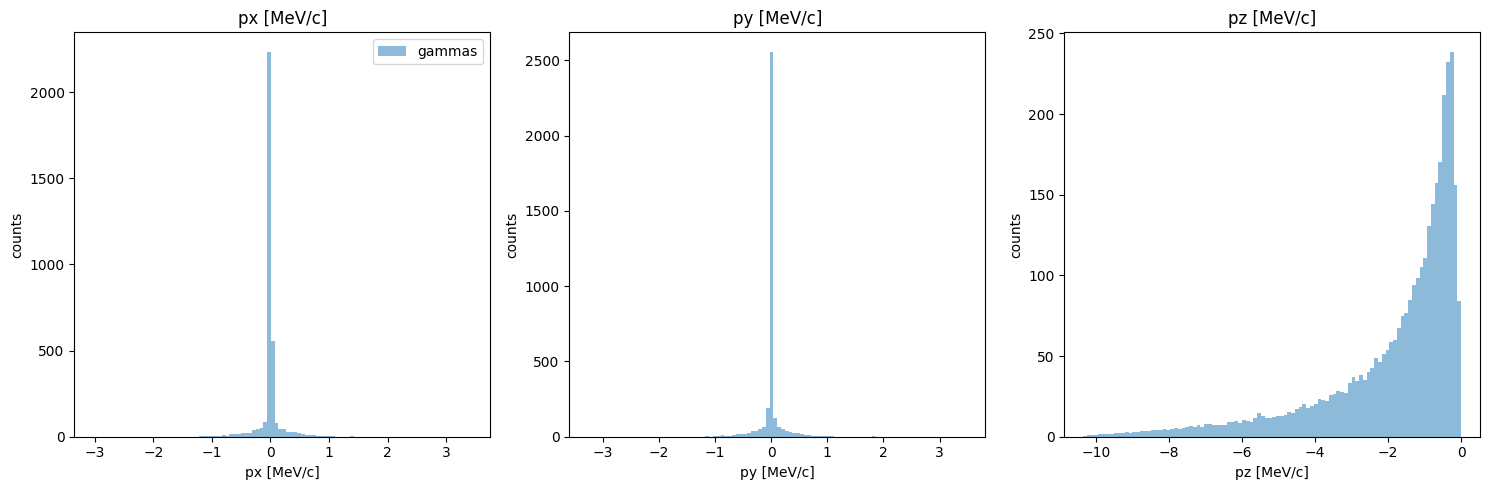

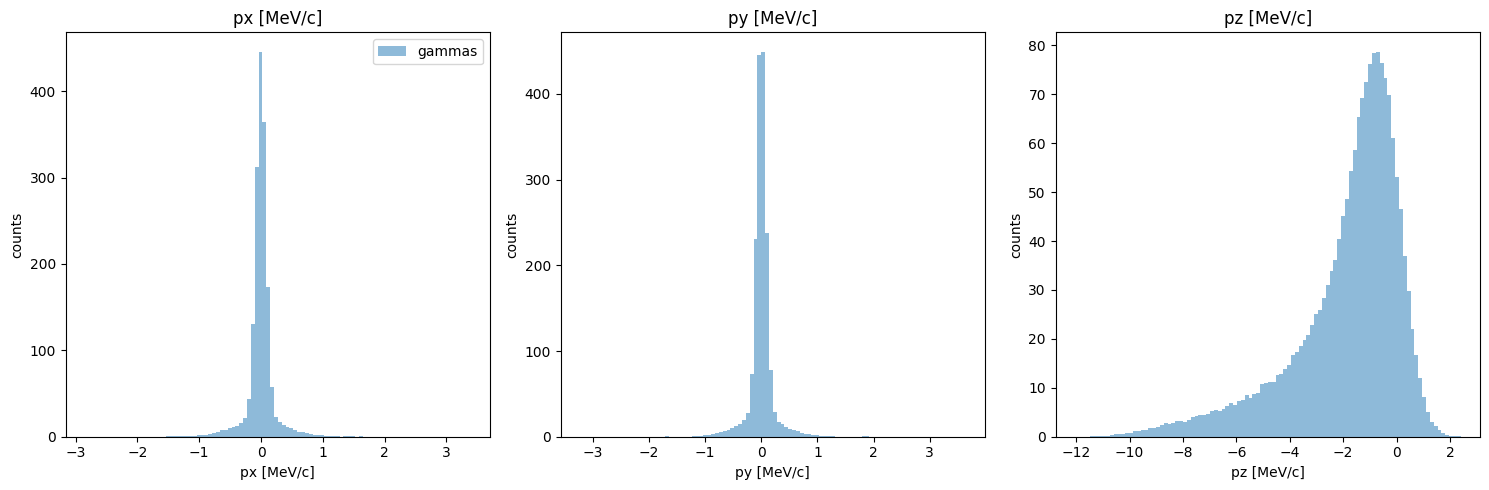

In [3]:
PS.plot_momentum_hist_1D()
new_PS.plot_momentum_hist_1D()

You can see that in the original data, all values of pz are negative, but in the KDE generated data, the momentums are positive. This is a [general problem with KDE](https://medium.com/mlearning-ai/density-estimation-for-bounded-variables-7d68f633e772); to solve it, we have two options:

1. remove all particles with pz>0 - the issue is that (a) this is a big chunk of our partilces, and (b) doing so would fundamentally change the energy histogram, which - although i haven't shown this - actually matches quite well.
2. Reflect the positive values into negative

I am going to take the second approach:

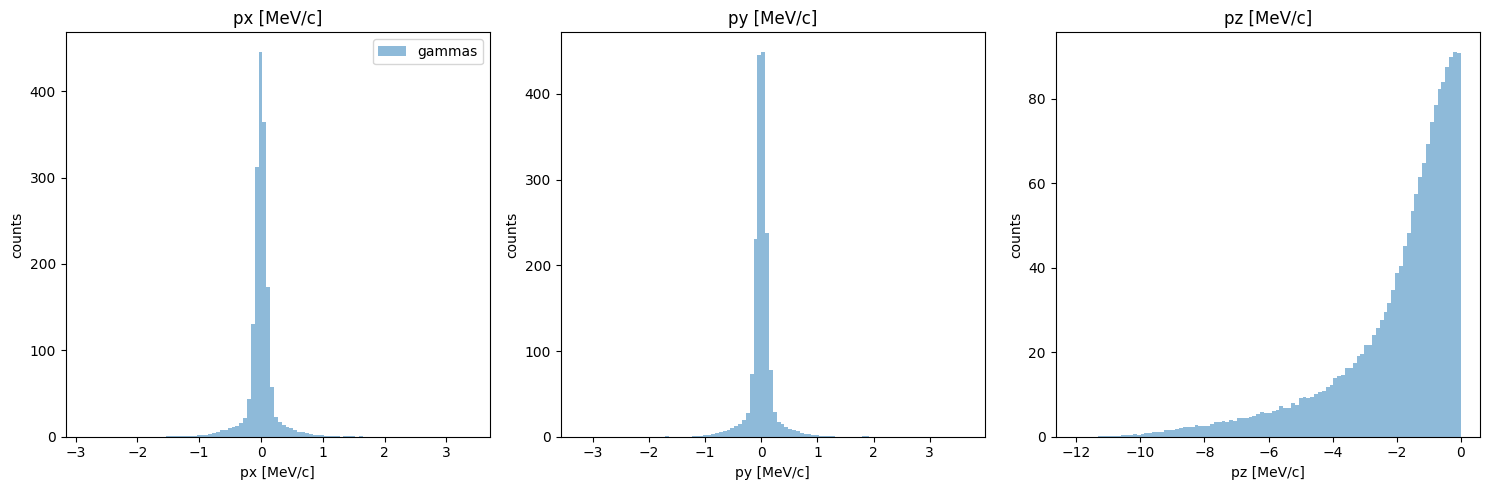

In [4]:
reflect_pz =True
if reflect_pz:
    new_PS.ps_data['pz [MeV/c]'] = -1* np.abs(new_PS.ps_data['pz [MeV/c]'])
    new_PS.reset_phase_space()
new_PS.plot_momentum_hist_1D()

Ok, momentum looks much closer now!
Note that I used the `reset_phase_space` method, [as is recomended](https://bwheelz36.github.io/ParticlePhaseSpace/basic_example.html#Manipulating-data-in-the-phase-space) whenever we interact directly with the phase space data like this.

### Remove high divergence particles

Let's take a look at the beam divergences:

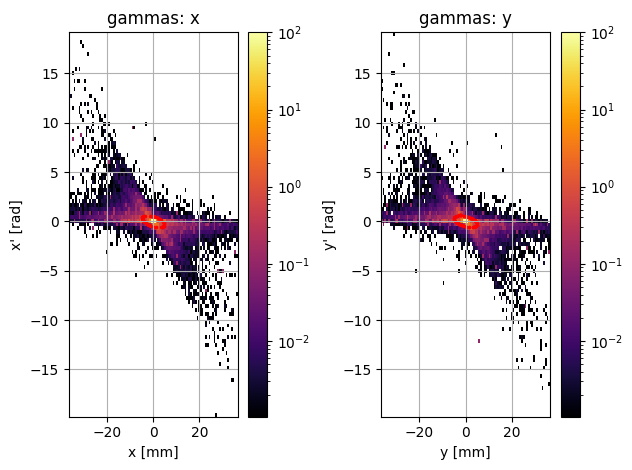

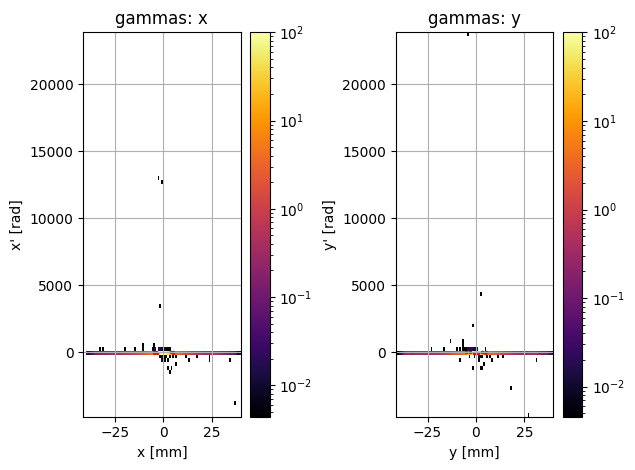

In [5]:
PS.plot_transverse_trace_space_hist_2D()
new_PS.plot_transverse_trace_space_hist_2D()

This is a bit of a disaster; these plots look completely different.
However, it actually appears that there are only a few outlier particles causing the second plot to look so different.
We could just try removing these particles:

removed 638 high divergence particles


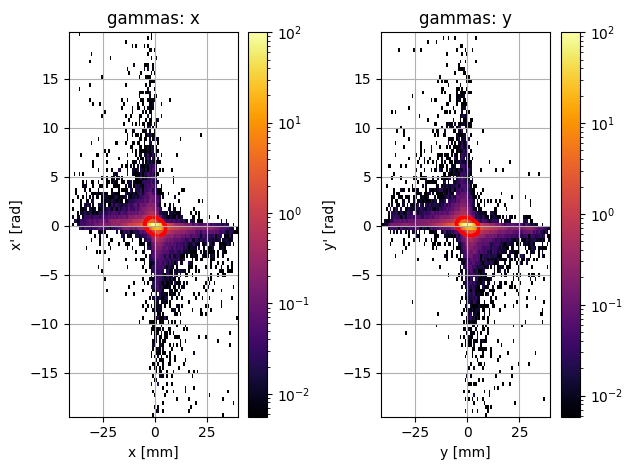

In [6]:
# remove particles that have higher divergence than the maximum divergence in the original data:
remove_high_divergence_particles=True
if remove_high_divergence_particles:
    div_x = np.abs(new_PS.ps_data['px [MeV/c]'] / new_PS.ps_data['pz [MeV/c]'])
    div_y = np.abs(new_PS.ps_data['py [MeV/c]'] / new_PS.ps_data['pz [MeV/c]'])
    max_div_x = np.max(np.abs(PS.ps_data['px [MeV/c]'] / PS.ps_data['pz [MeV/c]']))
    max_div_y = np.max(np.abs(PS.ps_data['py [MeV/c]'] / PS.ps_data['pz [MeV/c]']))
    rem_ind = np.logical_or(div_x > max_div_x, div_y > max_div_y)
    new_PS.ps_data = new_PS.ps_data[np.logical_not(rem_ind)].reset_index().drop('index', axis=1)
    new_PS.reset_phase_space()
    print(f'removed {np.count_nonzero(rem_ind)} high divergence particles')
new_PS.plot_transverse_trace_space_hist_2D()

This worked pretty well; by removing just a few outlier particles, we manged to get a phase space which looks much closer to the original!

Now that we have cleaned up the data, let's compare the original data to the downsampled data:

## Compare original to downsampled:

### Energy

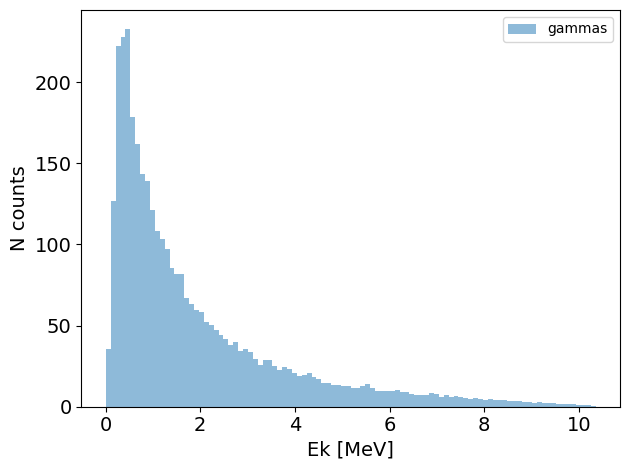

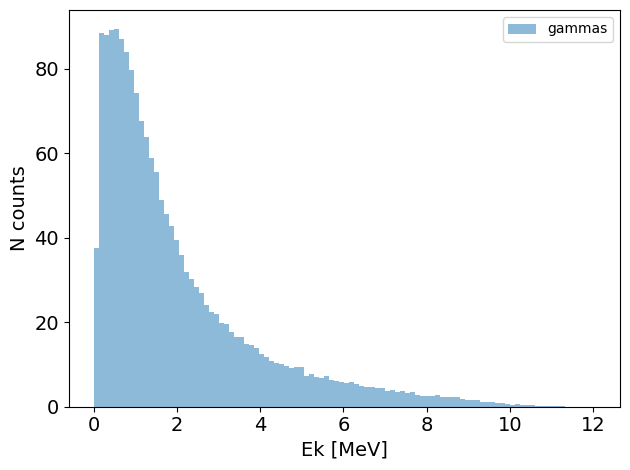

In [7]:
PS.plot_energy_hist_1D()
new_PS.plot_energy_hist_1D()

In [8]:
PS.print_energy_stats()
new_PS.print_energy_stats()

                 ENERGY STATS                  
total number of particles in phase space:  308280
number of unique particle species:  1
     308280 gammas
        mean energy:  1.91 MeV
        median energy:  1.20 MeV
        Energy spread IQR:  2.03 MeV
        min energy  0.01 MeV
        max energy  10.35 MeV


                 ENERGY STATS                  
total number of particles in phase space:  153502
number of unique particle species:  1
     153502 gammas
        mean energy:  2.03 MeV
        median energy:  1.38 MeV
        Energy spread IQR:  2.05 MeV
        min energy  0.01 MeV
        max energy  12.04 MeV


Looking pretty good!

### Particle Positions

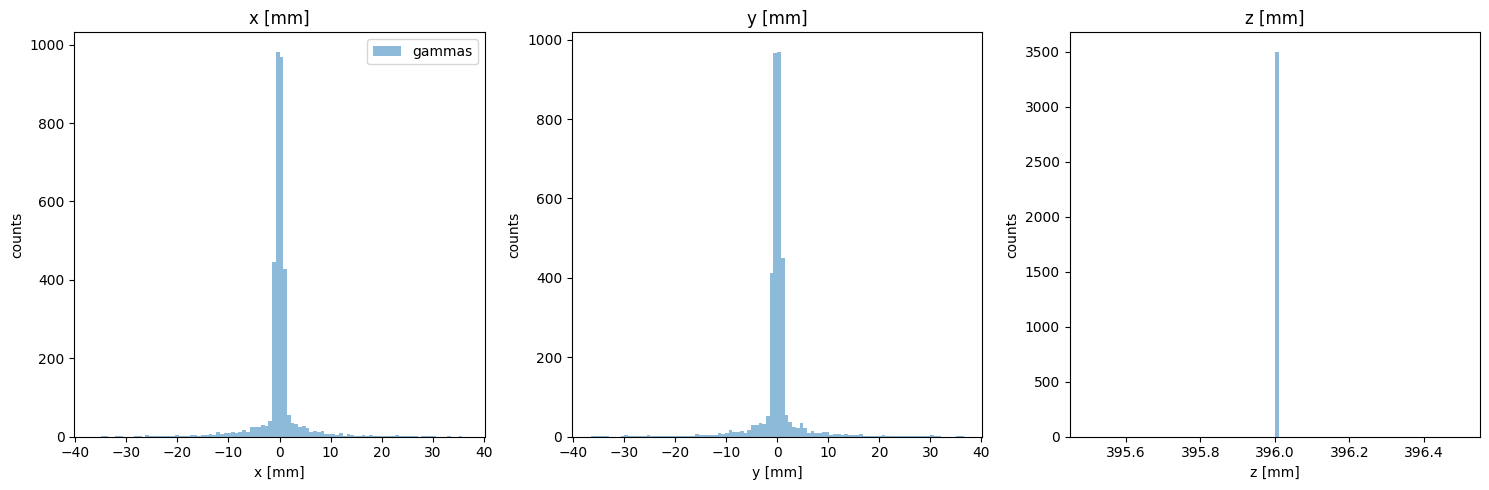

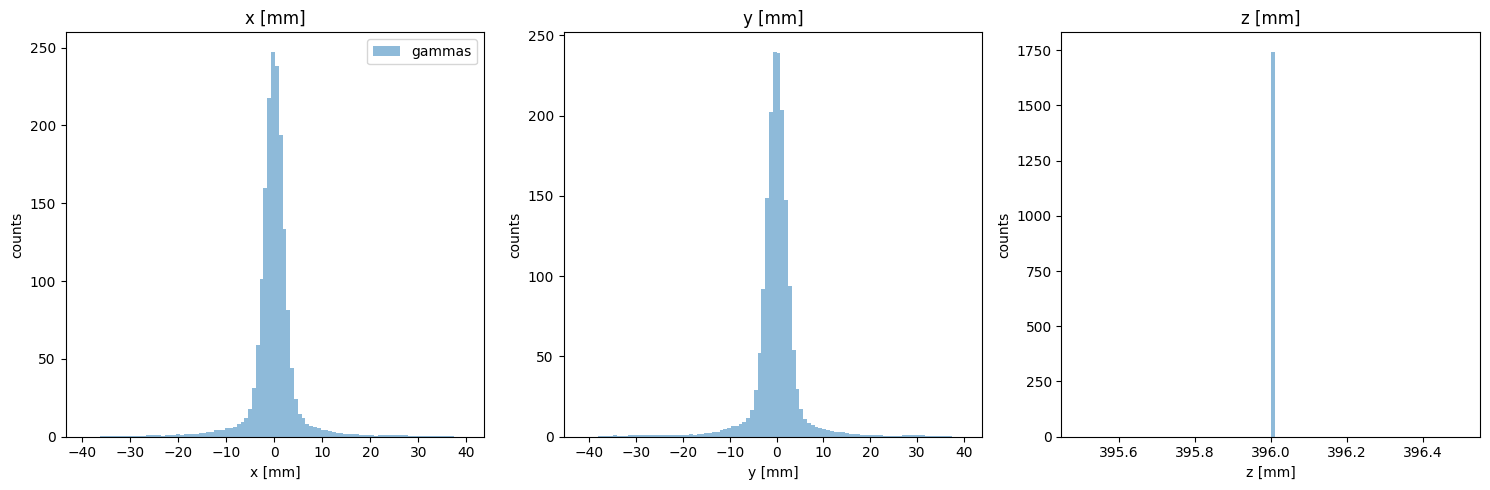

In [9]:
PS.plot_position_hist_1D()
new_PS.plot_position_hist_1D()

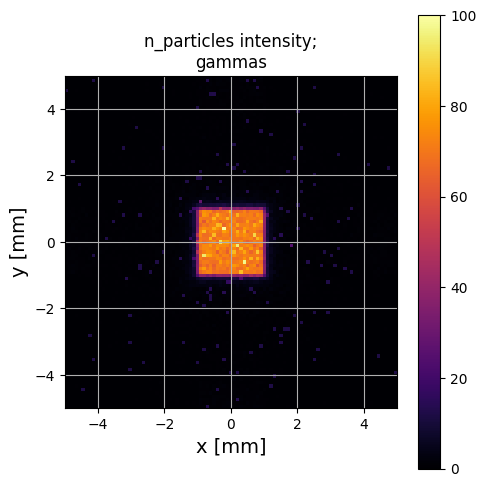

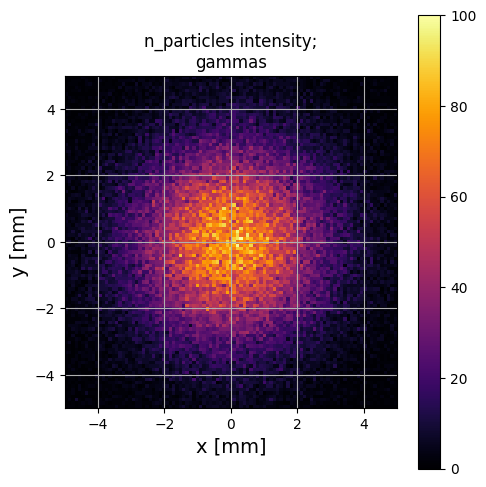

In [10]:
PS.plot_particle_positions_hist_2D(xlim=[-5,5], ylim=[-5,5])
new_PS.plot_particle_positions_hist_2D(xlim=[-5,5], ylim=[-5,5])

OK, this is quite interesting: [as explained previously](https://bwheelz36.github.io/ParticlePhaseSpace/basic_example.html) this data is scored below an X-ray collimator, which explains the extremely sharp distribution of x-rays. In the KDW estimate, this is not really being respected at all. We could try and address this with some more heuristic data cleaning steps as above, but for my applications, this artefact would probably rule out the use of this data.

Also interesting (and a good reminder!) is that this isn't really apparently at all from looking at the 1D histograms...

### Emittance

Apart from the plots (which we've already seen look pretty close) let's compare the twiss parameters

In [11]:
PS.print_twiss_parameters()
new_PS.print_twiss_parameters()

                 TWISS PARAMETERS                  

gammas:
                x         y
epsilon  2.525901  2.673361
alpha    0.619585  0.525727
beta     8.976938  9.488084
gamma    0.154160  0.134526
                 TWISS PARAMETERS                  

gammas:
                x         y
epsilon  4.497027  4.814717
alpha    0.277484  0.264453
beta     5.629677  5.974881
gamma    0.191307  0.179072


Also a reasonably good match in trace space...